In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

In [2]:
from midas.kmers import KmerSpec, find_kmers_parse, vec_to_coords
from midas.cython.metrics import jaccard_coords
from midas.cython.seqs import coords_dtype

In [3]:
outdir = Path('../../data/processed/200817-ecoli-sequence-identity')
outdir.mkdir(exist_ok=True)

## Load/find data

### Sequences

In [4]:
seqdir = Path('/Users/student/projects/midas/data2/200817-ecoli-genomes-for-identity/')

In [5]:
seqfiles = sorted(seqdir.glob('*.fasta'))
nseqs = len(seqfiles)

In [6]:
keys = [int(re.match(r'^SCU-(\d\d\d)', f.stem).group(1)) for f in seqfiles]
keys

[101, 102, 103, 108, 484, 485]

### Alignment identity

In [7]:
df = pd.read_csv('../../data/external/200816-ecoli-alignment-identity.csv', index_col=[0, 1])
df

n_aligned  n_unaligned  pct_aligned  pct_identity
genome1 genome2                                                   
101     102        5731946       425061         93.1          68.1
        103        5978705       451539         93.0          69.3
        108        5502311       403277         93.2          80.9
        484        5532599       325596         94.4          82.5
        485        5625051        84460         98.5          76.4
102     103        5791542        51356         99.1          70.2
        108        5718209       133584         97.7          68.7
        484        5555003       322909         94.5          71.5
        485        5273299        53307         99.0          71.2
103     108        5509195       586106         90.4          71.2
        484        5675894       511245         91.7          69.2
        485        5779862        93469         98.4          66.4
108     484        5211565       360106         93.5          86.9
        485        4633865       201748         95.8          85.1
484     485        4657117        83616         98.2          84.6

In [8]:
pct_identity = np.zeros((nseqs, nseqs))

for i in range(nseqs):
    pct_identity[i, i] = 100
    for j in range(i):
        pct_identity[i, j] = pct_identity[j, i] = df.loc[(keys[j], keys[i]), 'pct_identity']

Text(0.5, 1.05, 'Alignment Identity')

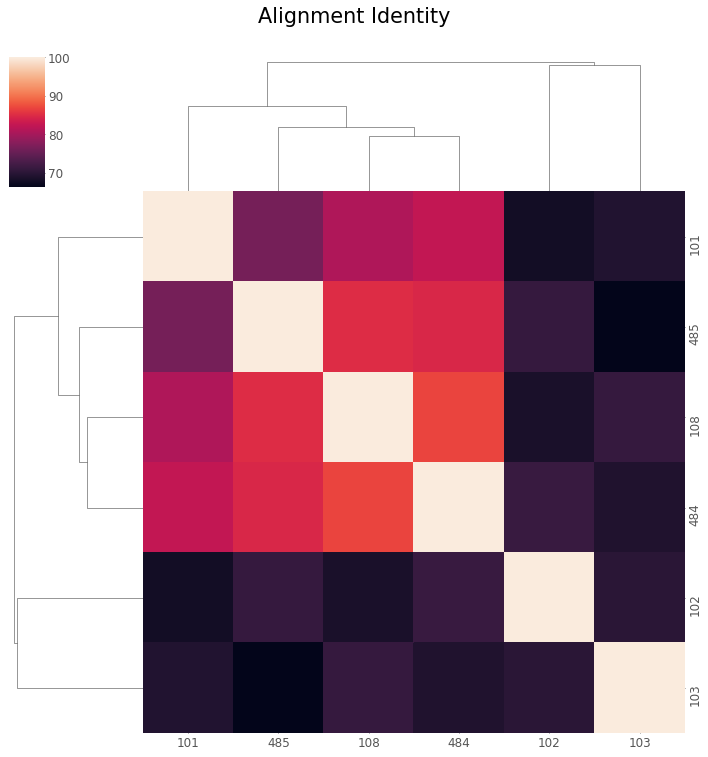

In [9]:
identity_link = sch.linkage(squareform(100 - pct_identity), method='average')
sns.clustermap(pct_identity, xticklabels=keys, yticklabels=keys, row_linkage=identity_link, col_linkage=identity_link)
plt.suptitle('Alignment Identity', fontsize='xx-large', y=1.05)

## Compute signatures and scores

In [10]:
kspec = KmerSpec(11, 'ATGAC')

In [11]:
sigs = [
    vec_to_coords(find_kmers_parse(kspec, f, 'fasta')).astype(coords_dtype)
    for f in tqdm(seqfiles)
]

100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


In [12]:
scores = np.ones((nseqs, nseqs))

for i in range(nseqs):
    for j in range(i):
        scores[i, j] = scores[j, i] = jaccard_coords(sigs[i], sigs[j])

Text(0.5, 1.05, 'Jaccard Similarity')

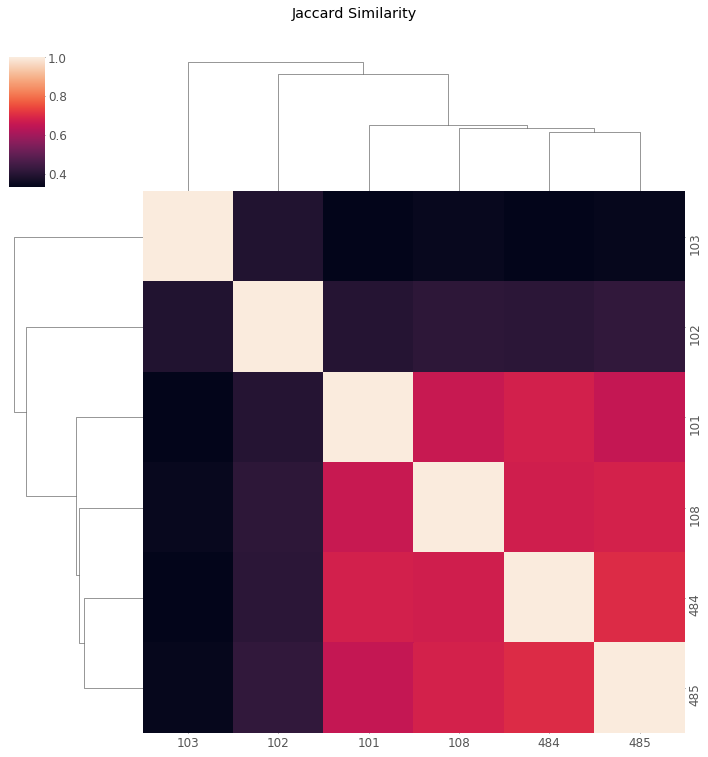

In [14]:
score_link = sch.linkage(squareform(1 - scores), method='average')
sns.clustermap(scores, xticklabels=keys, yticklabels=keys, row_linkage=score_link, col_linkage=score_link)
plt.suptitle('Jaccard Similarity', y=1.05)

### Write table

In [15]:
df['jaccard'] = [scores[keys.index(k1), keys.index(k2)] for k1, k2 in df.index]

In [16]:
df.to_csv(outdir / '200817-ecoli-pairwise-identity-jaccard-comparison.csv')

## Compare

Text(0, 0.5, 'Jaccard Similarity')

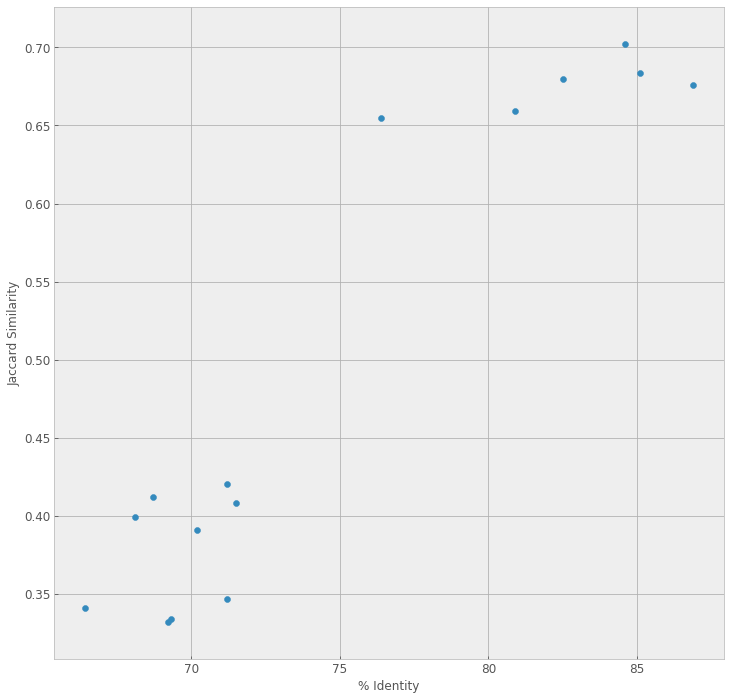

In [17]:
plt.figure(figsize=(12, 12))
plt.scatter(df['pct_identity'], df['jaccard'])
plt.xlabel('% Identity')
plt.ylabel('Jaccard Similarity')

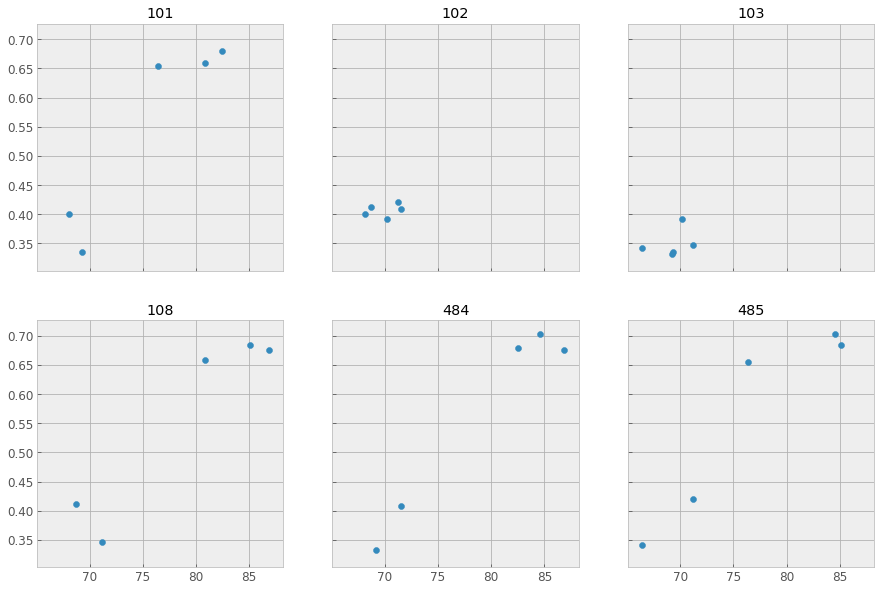

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    ax.set_title(keys[i])
    ax.scatter(np.delete(pct_identity[i, :], i), np.delete(scores[i, :], i))